In [1]:
import os, glob, pickle, json, time
from PIL import Image, ImageDraw
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torch.amp import autocast, GradScaler
from tqdm import tqdm

import json # Needed for loading annotations
import time # Needed for the load_annotations retry logic
import cv2  # Needed for warp_roi
import glob # Needed to find pkl files

In [20]:
# — 경로 설정 및 어노테이션 로드 —
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = '/content/drive/MyDrive/pt_data'
WEIGHTS_PATH = os.path.join(DATA_ROOT, 'model_weights/')

AIHUB_ANN = os.path.join(DATA_ROOT, 'aihub_annotations.json')
RDD_ANN   = os.path.join(DATA_ROOT, 'rdd2022_train_annotations.json')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_and_consolidate_annotations(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    consolidated = {}
    if isinstance(data, list):
        for item in data:
            fn = item.get('file_name')
            if not fn: continue
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
    elif isinstance(data, dict):
        # 이미 dict 형태일 때도 key 처리
        for fn, item in data.items():
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
        for item in data.get('annotations', []):
            fn = item.get('file_name')
            if not fn: continue
            base = os.path.splitext(fn)[0]
            consolidated[base] = item
    return consolidated

In [4]:
# Load and consolidate annotations from both files
aihub_ann_dict = load_and_consolidate_annotations(AIHUB_ANN)
rdd_ann_dict   = load_and_consolidate_annotations(RDD_ANN)

# Combine the two dictionaries
ann_dict = {**aihub_ann_dict, **rdd_ann_dict}

In [5]:
# — 파일 목록 준비 —
train_pkls = glob.glob(os.path.join(DATA_ROOT, 'AIhub_Road',    'training_image_batch_*.pkl')) + \
             glob.glob(os.path.join(DATA_ROOT, 'RDD2022',        'training_image_batch_*.pkl'))
val_pkls   = glob.glob(os.path.join(DATA_ROOT, 'AIhub_Road',    'validation_image_batch_*.pkl')) + \
             glob.glob(os.path.join(DATA_ROOT, 'RDD2022',        'validation_image_batch_*.pkl'))

In [6]:
from albumentations.augmentations.crops.transforms import CropNonEmptyMaskIfExists as cropnoemptymaskifexists

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [17]:
# — 트랜스폼 정의 —
seg_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
import os, glob, pickle, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw

In [8]:
# 클래스별 색상맵 정의 (0=transparent, 1=red, 2=blue)
cmap = mcolors.ListedColormap([
    (0,0,0,0),      # 배경: 투명
    (1,0,0,0.5),    # label=0 → red, alpha=0.5
    (0,0,1,0.5),    # label=1 → blue, alpha=0.5
])

In [9]:
def create_mask_binary(annotations, shape):
    H, W = shape
    mask = np.zeros((H, W), dtype=np.int64)
    for ann in annotations:
        x, y, w, h = ann['bbox']
        x0, y0 = map(int, map(round, (x, y)))
        x1 = x0 + int(round(w)) - 1
        y1 = y0 + int(round(h)) - 1
        if x1 > x0 and y1 > y0:
            mask[y0:y1+1, x0:x1+1] = 1
    return mask

<ipython-input-10-d780be6c46cb>:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(f)


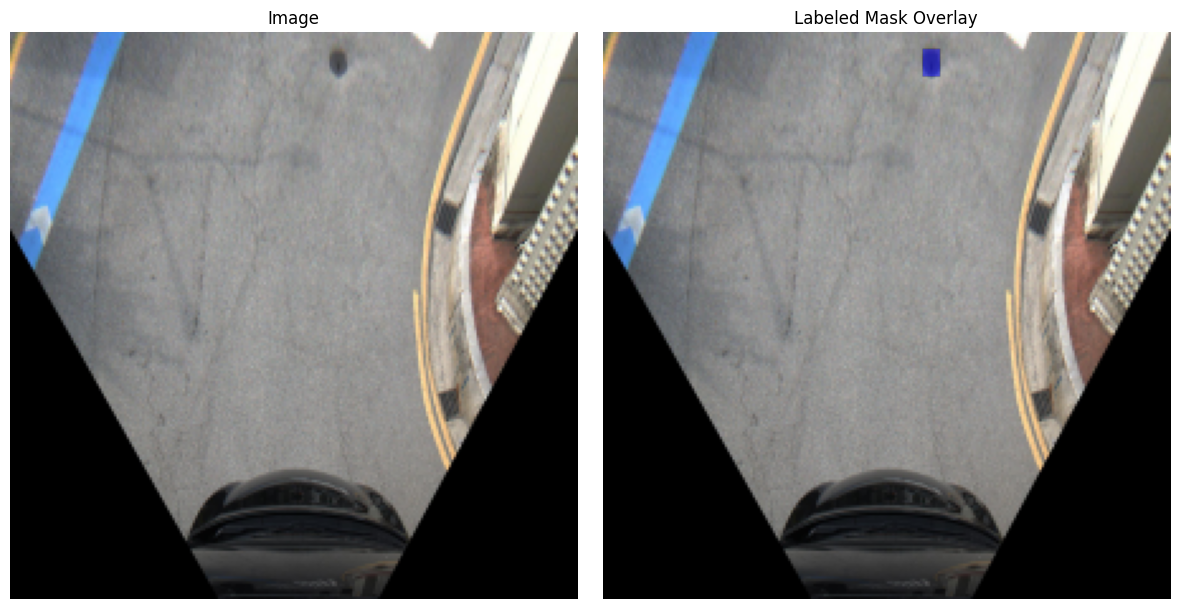

SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
for pklf in train_pkls:
    with open(pklf, 'rb') as f:
        batch = pickle.load(f)

    items = batch.items() if isinstance(batch, dict) else [(e['filename'], e) for e in batch]

    for fname, entry in items:
        anns = ann_dict.get(fname, {}).get('annotations', [])
        if not anns:
            continue

        # 원본 이미지 BGR→RGB
        arr = entry['image'][..., ::-1].copy()

        # 멀티클래스 마스크 생성 (0,1,2)
        mask = create_mask_binary(anns, arr.shape[:2])

        # 시각화
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(arr.astype('uint8'))
        axes[0].set_title('Image')
        axes[0].axis('off')

        axes[1].imshow(arr.astype('uint8'))
        axes[1].imshow(mask, cmap=cmap)
        axes[1].set_title('Labeled Mask Overlay')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
        raise SystemExit

In [11]:
import sys
import torch
import pickle
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

In [12]:
def get_deeplab_model(num_classes):
    model = deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    #aspp = model.classifier[0]
    #aspp.pool = nn.Sequential(
    #    nn.AdaptiveAvgPool2d(1),
    #    nn.Conv2d(2048, 256, 1, bias=False),
    #    nn.GroupNorm(num_groups=32, num_channels=256),
    #    nn.ReLU()
    #)
    return model

In [13]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = get_deeplab_model(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler    = GradScaler()
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 230MB/s]
<ipython-input-13-ccee1c1995cc>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradSc

In [14]:
seg_bs = 16
epochs = 15

In [15]:
train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

In [16]:
crop_fn = cropnoemptymaskifexists(height=224, width=224)

In [18]:
def train_epoch(epoch):
    model.train()
    total_loss, total_correct, total_pixels = 0.0, 0, 0
    # n_batches calculation might need adjustment if we skip small batches
    # A more accurate way would be to count batches *after* collection and filtering
    # For now, we'll keep the original calculation but acknowledge it might be slightly off
    n_batches = sum((len(pickle.load(open(pklf,'rb'))) + seg_bs - 1)//seg_bs
                    for pklf in train_pkls)
    pbar = tqdm(total=n_batches, desc=f"Epoch {epoch} Train",
                unit="batch", ncols=80, file=sys.stdout, leave=False)

    for pklf in train_pkls:
        batch = pickle.load(open(pklf,'rb'))
        for i in range(0, len(batch), seg_bs):
            slice_ = batch[i:i+seg_bs]
            imgs, masks = [], []

            for entry in slice_:
                fn, arr = entry['filename'], entry['image']
                anns = ann_dict.get(fn, {}).get('annotations', [])
                if not anns:
                    continue

                img_pil = Image.fromarray(arr[..., ::-1].astype(np.uint8))
                mask_np = create_mask_binary(anns, arr.shape[:2])
                # It might be beneficial to apply augmentation first and then filter based on mask presence/size
                # but for now, we address the immediate batch size issue.
                aug = crop_fn(image=np.array(img_pil), mask=mask_np)
                img_crop = Image.fromarray(aug['image'])
                mask_crop = aug['mask']

                img_t = seg_tf(img_crop)
                imgs.append(img_t)
                masks.append(torch.from_numpy(mask_crop).long())

            # --- Suggested Change ---
            # Skip batches with size less than 2 to avoid ValueError in Batch Norm
            if len(imgs) < 2:
                # We should ideally decrement pbar total here if we skip batches,
                # but for simplicity, we just update the bar.
                # The batch count `n_batches` will be an upper bound.
                pbar.update()
                continue
            # --- End Suggested Change ---


            # The DataLoader will now receive at least 2 samples if this point is reached
            loader = DataLoader(
                TensorDataset(torch.stack(imgs), torch.stack(masks)),
                batch_size=len(imgs), # Use the actual number of collected samples as batch size
                shuffle=True, num_workers=0, pin_memory=False
            )
            for x, y in loader:
                # x, y will now have a batch size >= 2
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                with autocast():
                    out  = model(x)['out']
                    loss = criterion(out, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                total_loss   += loss.item()
                preds        = out.argmax(dim=1)
                total_correct += (preds == y).sum().item()
                total_pixels  += y.numel()
                pbar.update()

    pbar.close()
    # The metrics might be slightly off due to skipped batches,
    # but the training process should be stable.
    return total_loss / (total_pixels / (224*224)) if total_pixels > 0 else 0.0, total_correct / total_pixels if total_pixels > 0 else 0.0 # Divide by processed pixels instead of theoretical batches

In [19]:
def validate_epoch(epoch):
    model.eval()
    total_loss, total_correct, total_pixels = 0.0, 0, 0
    # n_batches calculation might need adjustment if we skip small batches
    n_batches = sum((len(pickle.load(open(pklf,'rb'))) + seg_bs - 1)//seg_bs
                    for pklf in val_pkls)
    pbar = tqdm(total=n_batches, desc=f"Epoch {epoch} Val",
                unit="batch", ncols=80, file=sys.stdout, leave=False)

    with torch.no_grad():
        for pklf in val_pkls:
            batch = pickle.load(open(pklf,'rb'))
            for i in range(0, len(batch), seg_bs):
                slice_ = batch[i:i+seg_bs]
                imgs, masks = [], []

                for entry in slice_:
                    fn, arr = entry['filename'], entry['image']
                    anns = ann_dict.get(fn, {}).get('annotations', [])
                    if not anns:
                        continue

                    img_pil = Image.fromarray(arr[..., ::-1].astype(np.uint8))
                    mask_np = create_mask_binary(anns, arr.shape[:2])
                    aug = crop_fn(image=np.array(img_pil), mask=mask_np)
                    img_crop = Image.fromarray(aug['image'])
                    mask_crop = aug['mask']

                    img_t = seg_tf(img_crop)
                    imgs.append(img_t)
                    masks.append(torch.from_numpy(mask_crop).long())

                # --- Suggested Change ---
                # Skip batches with size less than 2
                if len(imgs) < 2:
                    pbar.update()
                    continue
                # --- End Suggested Change ---

                loader = DataLoader(
                    TensorDataset(torch.stack(imgs), torch.stack(masks)),
                    batch_size=len(imgs), # Use the actual number of collected samples
                    shuffle=False, num_workers=0, pin_memory=False
                )
                for x, y in loader:
                    x, y = x.to(device), y.to(device)
                    with autocast():
                        out  = model(x)['out']
                        loss = criterion(out, y)

                    total_loss   += loss.item()
                    preds         = out.argmax(dim=1)
                    total_correct += (preds == y).sum().item()
                    total_pixels  += y.numel()
                    pbar.update()

    pbar.close()
    # Divide by processed pixels
    return total_loss / (total_pixels / (224*224)) if total_pixels > 0 else 0.0, total_correct / total_pixels if total_pixels > 0 else 0.0

## 5 Epochs Load + 15 Epochs

In [21]:
model.load_state_dict(torch.load(WEIGHTS_PATH+'/deeplabv3_ep5.pth', map_location=device))

<All keys matched successfully>

In [22]:
train_losses, train_accs = [], []
val_losses,   val_accs   = [], []

In [23]:
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_epoch(epoch)
    val_loss, val_acc = validate_epoch(epoch)
    torch.save(model.state_dict(), f"deeplabv3_ep{epoch}.pth")
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(val_loss);     val_accs.append(val_acc)
    print(f"Epoch {epoch} | Train L:{tr_loss:.6f} A:{tr_acc:.4f} | Val L:{val_loss:.6f} A:{val_acc:.4f}")

<ipython-input-18-6653ad0eb2c4>:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  n_batches = sum((len(pickle.load(open(pklf,'rb'))) + seg_bs - 1)//seg_bs


Epoch 1 Train:   0%|                               | 0/13124 [00:00<?, ?batch/s]

<ipython-input-18-6653ad0eb2c4>:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf,'rb'))


Epoch 1 Train:   0%|                     | 1/13124 [00:00<2:23:06,  1.53batch/s]

<ipython-input-18-6653ad0eb2c4>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


<ipython-input-19-077d305dddc5>:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  n_batches = sum((len(pickle.load(open(pklf,'rb'))) + seg_bs - 1)//seg_bs


Epoch 1 Val:   0%|                                  | 0/1641 [00:00<?, ?batch/s]

<ipython-input-19-077d305dddc5>:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf,'rb'))


Epoch 1 Val:   1%|▎                        | 23/1641 [00:00<00:39, 41.10batch/s]

<ipython-input-19-077d305dddc5>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Train L:0.004063 A:0.9785 | Val L:0.007637 A:0.9671
Epoch 2 | Train L:0.003691 A:0.9803 | Val L:0.007473 A:0.9676
Epoch 3 | Train L:0.003437 A:0.9815 | Val L:0.007528 A:0.9676
Epoch 4 | Train L:0.003143 A:0.9831 | Val L:0.007183 A:0.9691
Epoch 5 | Train L:0.002965 A:0.9839 | Val L:0.007089 A:0.9694
Epoch 6 | Train L:0.002794 A:0.9848 | Val L:0.010563 A:0.9576
Epoch 7 | Train L:0.002656 A:0.9855 | Val L:0.008717 A:0.9640
Epoch 8 | Train L:0.002494 A:0.9864 | Val L:0.008099 A:0.9685
Epoch 9 | Train L:0.002365 A:0.9870 | Val L:0.007991 A:0.9669
Epoch 10 | Train L:0.002253 A:0.9876 | Val L:0.007859 A:0.9682
Epoch 11 | Train L:0.002152 A:0.9882 | Val L:0.008067 A:0.9689
Epoch 12 | Train L:0.002006 A:0.9889 | Val L:0.007744 A:0.9706
Epoch 13 | Train L:0.001941 A:0.9893 | Val L:0.008613 A:0.9683
Epoch 14 | Train L:0.001864 A:0.9897 | Val L:0.008731 A:0.9684
Epoch 15 | Train L:0.001738 A:0.9903 | Val L:0.008700 A:0.9696


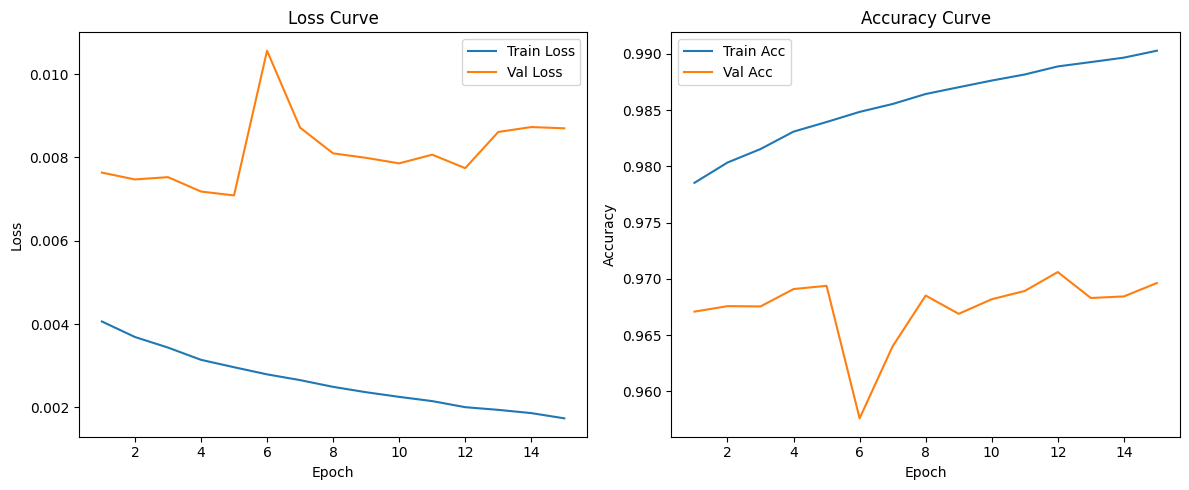

In [24]:
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()

In [25]:
import random
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
from matplotlib.colors import ListedColormap

In [27]:
def visualize_predictions(
    model,
    pkls,
    ann_dict,
    seg_tf,
    create_mask_binary,
    device,
    num_samples=10
):
    model.eval()
    samples = []
    for pklf in pkls:
        batch = pickle.load(open(pklf, 'rb'))
        for entry in batch:
            fn = entry['filename']
            arr = entry['image']
            anns = ann_dict.get(fn, {}).get('annotations', [])
            gt_mask = create_mask_binary(anns, arr.shape[:2])
            if not gt_mask.any():
                continue
            rgb = arr[..., ::-1]
            samples.append((rgb, gt_mask))
    samples = random.sample(samples, min(num_samples, len(samples)))

    cmap = ListedColormap([
        (0, 0, 0, 0),
        (1, 0, 0, 0.5),
    ])

    fig, axes = plt.subplots(len(samples), 3, figsize=(12, 4 * len(samples)))
    for i, (rgb, gt_mask) in enumerate(samples):
        ax0 = axes[i, 0] if len(samples) > 1 else axes[0]
        ax0.imshow(rgb.astype('uint8'))
        ax0.set_title('Original Image')
        ax0.axis('off')

        ax1 = axes[i, 1] if len(samples) > 1 else axes[1]
        ax1.imshow(rgb.astype('uint8'))
        ax1.imshow(gt_mask, cmap=cmap, vmin=0, vmax=1, alpha=0.5)
        gt_labels = np.unique(gt_mask).tolist()
        ax1.set_title(f'GT Mask\nlabels: {gt_labels}')
        ax1.axis('off')

        img_t = seg_tf(Image.fromarray(rgb.astype(np.uint8))).unsqueeze(0).to(device)
        with torch.no_grad(), autocast():
            out = model(img_t)['out']
        pred_mask = out.argmax(dim=1).squeeze(0).cpu().numpy()

        ax2 = axes[i, 2] if len(samples) > 1 else axes[2]
        ax2.imshow(rgb.astype('uint8'))
        ax2.imshow(pred_mask, cmap=cmap, vmin=0, vmax=1, alpha=0.5)
        pred_labels = np.unique(pred_mask).tolist()
        ax2.set_title(f'Pred Mask\nlabels: {pred_labels}')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
testmodel = get_deeplab_model(2)
testmodel.to(device)
testmodel.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [29]:
testmodel.load_state_dict(torch.load('deeplabv3_ep15.pth', map_location=device))

<All keys matched successfully>

<ipython-input-27-17f276d84899>:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf, 'rb'))
<ipython-input-27-17f276d84899>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


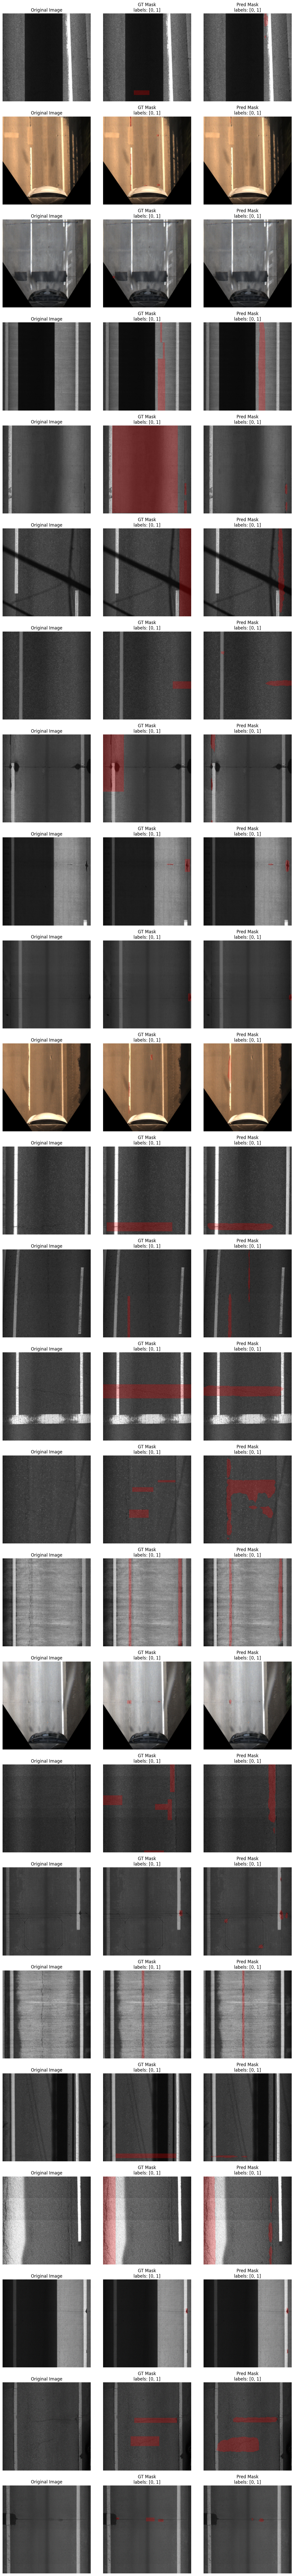

In [30]:

visualize_predictions(
    model=testmodel,
    pkls=val_pkls,
    ann_dict=ann_dict,
    seg_tf=seg_tf,
    create_mask_binary=create_mask_binary,
    device=device,
    num_samples=25
)

In [34]:
def pixel_accuracy(preds, target):
    return (preds == target).float().mean()

def class_iou(preds, target, num_classes):
    ious = []
    # Get the device of the input tensors
    device = preds.device
    for c in range(num_classes):
        p = preds == c
        t = target == c
        inter = (p & t).sum().float()
        union = (p | t).sum().float()
        # Ensure the 0.0 tensor is on the correct device
        ious.append(inter / union if union > 0 else torch.tensor(0.0).to(device))
    return ious

def mean_iou(ious):
    return torch.stack(ious).mean()

def dice_coefficient(preds, target, num_classes):
    dices = []
    # Get the device of the input tensors
    device = preds.device
    for c in range(num_classes):
        p = preds == c
        t = target == c
        inter = (p & t).sum().float()
        denom = p.sum().float() + t.sum().float()
        # Ensure the 0.0 tensor is on the correct device
        dices.append(2 * inter / denom if denom > 0 else torch.tensor(0.0).to(device))
    return dices


def mean_average_precision(out, target, num_classes):
    probs = torch.nn.functional.softmax(out, dim=1).cpu().detach().numpy()
    t = target.cpu().numpy()
    aps = []
    for c in range(num_classes):
        gt = (t == c).flatten()
        pr = probs[:, c, :, :].flatten()
        if gt.sum() == 0:
            continue
        aps.append(average_precision_score(gt, pr))
    return aps

def debug_batch(x, y, out, batch_idx=0, num_classes=2):
    preds = out.argmax(dim=1)
    print(f"[Batch {batch_idx}] PixelAcc: {pixel_accuracy(preds, y):.4f}")
    ious = class_iou(preds, y, num_classes)
    for c, iou in enumerate(ious):
        print(f"  IoU class {c}: {iou:.4f}")
    print(f"  mIoU: {mean_iou(ious):.4f}")
    dices = dice_coefficient(preds, y, num_classes)
    for c, d in enumerate(dices):
        print(f"  Dice class {c}: {d:.4f}")
    aps = mean_average_precision(out, y, num_classes)
    for idx, ap in enumerate(aps):
        print(f"  AP class {idx}: {ap:.4f}")
    if aps:
        print(f"  mAP: {sum(aps)/len(aps):.4f}")


In [35]:
num_classes=2

In [37]:
from sklearn.metrics import average_precision_score

In [38]:
for epoch in range(1, epochs + 1):
    model.train()
    sum_loss = 0.0
    sum_pix_acc = 0.0
    sum_miou = 0.0
    sum_map = 0.0
    count = 0

    for pklf in train_pkls:
        batch = pickle.load(open(pklf, 'rb'))
        for i in range(0, len(batch), seg_bs):
            slice_ = batch[i:i + seg_bs]
            imgs, masks = [], []
            for entry in slice_:
                fn, arr = entry['filename'], entry['image']
                img_t = seg_tf(Image.fromarray(arr[..., ::-1].astype('uint8')))
                anns = ann_dict.get(fn, {}).get('annotations', [])
                mask = create_mask_binary(anns, arr.shape[:2])
                imgs.append(img_t)
                masks.append(torch.from_numpy(mask).long())
            if not imgs:
                continue

            x = torch.stack(imgs).to(device)
            y = torch.stack(masks).to(device)
            optimizer.zero_grad()
            out = model(x)['out']
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = out.argmax(dim=1)
            sum_loss += loss.item()
            sum_pix_acc += pixel_accuracy(preds, y).item()
            ious = class_iou(preds, y, num_classes)
            sum_miou += mean_iou(ious).item()
            aps = mean_average_precision(out, y, num_classes)
            sum_map += sum(aps) / len(aps) if aps else 0.0
            count += 1

            if epoch == 1 and i == 0:
                debug_batch(x, y, out, batch_idx=0, num_classes=num_classes)

    avg_loss = sum_loss / count
    avg_pix_acc = sum_pix_acc / count
    avg_miou = sum_miou / count
    avg_map = sum_map / count
    print(f"[Epoch {epoch}] Loss: {avg_loss:.6f}, PixAcc: {avg_pix_acc:.4f}, mIoU: {avg_miou:.4f}, mAP: {avg_map:.4f}")



<ipython-input-38-70a9302b3849>:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf, 'rb'))


[Batch 0] PixelAcc: 0.9996
  IoU class 0: 0.9996
  IoU class 1: 0.0000
  mIoU: 0.4998
  Dice class 0: 0.9998
  Dice class 1: 0.0000
  AP class 0: 1.0000
  mAP: 1.0000


<ipython-input-38-70a9302b3849>:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  batch = pickle.load(open(pklf, 'rb'))


[Batch 0] PixelAcc: 1.0000
  IoU class 0: 1.0000
  IoU class 1: 0.0000
  mIoU: 0.5000
  Dice class 0: 1.0000
  Dice class 1: 0.0000
  AP class 0: 1.0000
  AP class 1: 0.0001
  mAP: 0.5000


KeyboardInterrupt: 